# Noise2Self for Neural Nets

This is a simple notebook demonstrating the principle of using self-supervision to train denoising networks.

For didactic purposes, we use a simple dataset (Gaussian noise on MNIST), a simple model (a small UNet), and a short training (100 iterations on a CPU). This notebook runs on a MacBook Pro in under one minute.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

c:\Users\ADMIN\anaconda3\envs\0726_noise2self\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

We demonstrate the use of a self-supervised denoising objective on a synthetically noised version of MNIST.

In [4]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset

mnist_train = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = True)

mnist_test = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = False)

In [5]:
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.4

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

In [6]:
noisy_mnist_train = SyntheticNoiseDataset(mnist_train, 'train')
noisy_mnist_test = SyntheticNoiseDataset(mnist_test, 'test')

We will try to learn to predict the clean image on the right from the noisy image on the left.

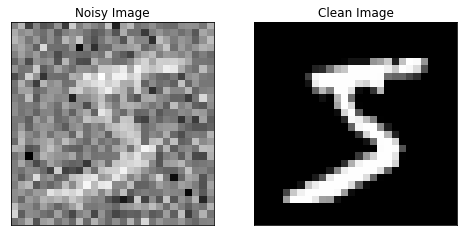

In [7]:
noisy, clean = noisy_mnist_train[0]
plot_tensors([noisy[0], clean[0]], ['Noisy Image', 'Clean Image'])

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [107]:
from mask import Masker
masker = Masker(width = -2, mode='zero')

In [103]:
net_input, mask = masker.mask(noisy.unsqueeze(0), 0)

A mask;

the data; 

the input to the neural net, which doesn't depend on the values of $x$ inside the mask; 

and the difference between the neural net input and $x$.

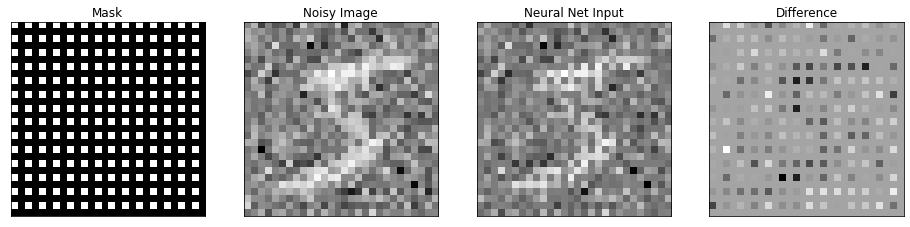

In [104]:
plot_tensors([mask, noisy[0], net_input[0], net_input[0] - noisy[0]],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference"])

In [98]:
mask

tensor([[1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [35]:
from models.dncnn import DnCNN
model = DnCNN(1, num_of_layers = 3)

In [22]:
net_output = model(net_input[0])

ValueError: expected 4D input (got 3D input)

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [36]:
from models.babyunet import BabyUnet
model = BabyUnet()

# Training

In [51]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

Loss ( 0 ): 	 9.9317
Loss ( 10 ): 	 0.3834


c:\Users\ADMIN\Desktop\SAR_image\noise2self\noise2self-master\notebooks\..\util.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, width, sharex='col', sharey='row', figsize=(width * 4, 4))


Loss ( 20 ): 	 0.0945
Loss ( 30 ): 	 0.0693
Loss ( 40 ): 	 0.0586
Loss ( 50 ): 	 0.0569
Loss ( 60 ): 	 0.0544
Loss ( 70 ): 	 0.0515
Loss ( 80 ): 	 0.0504
Loss ( 90 ): 	 0.0512
Loss ( 100 ): 	 0.0489


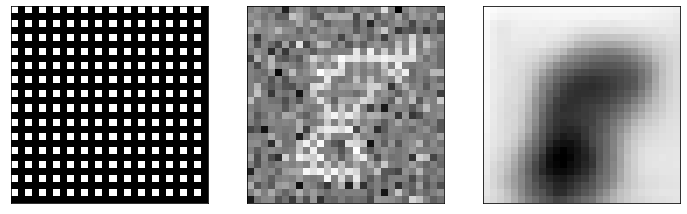

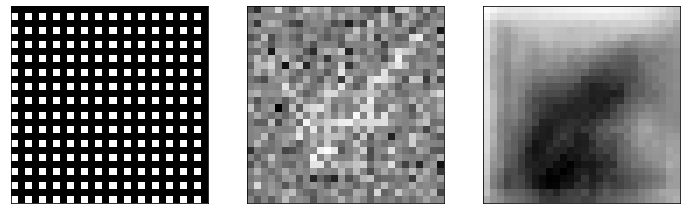

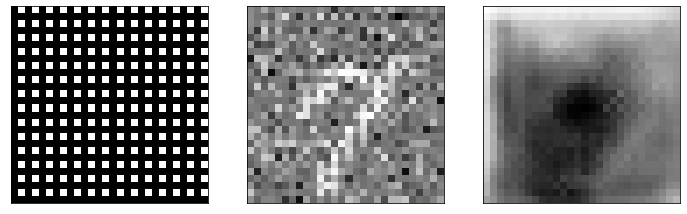

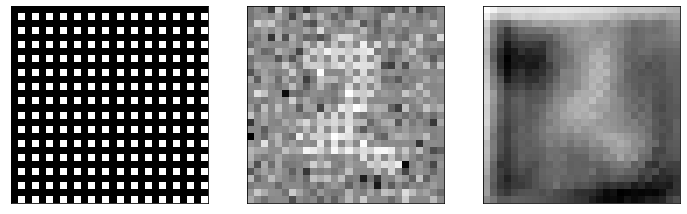

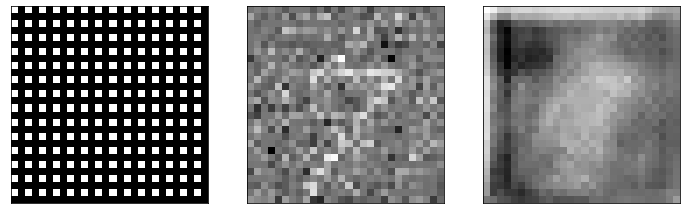

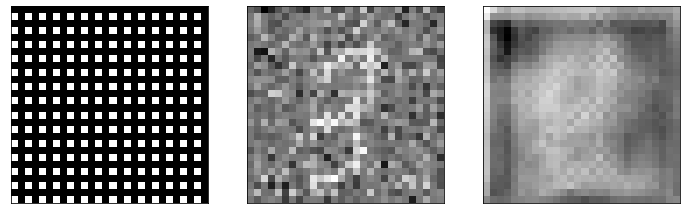

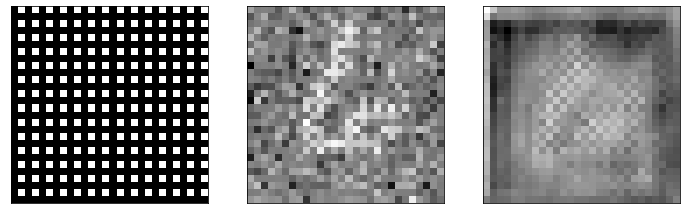

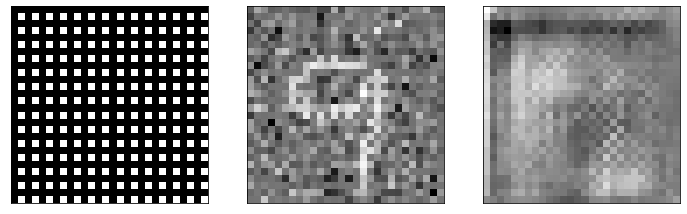

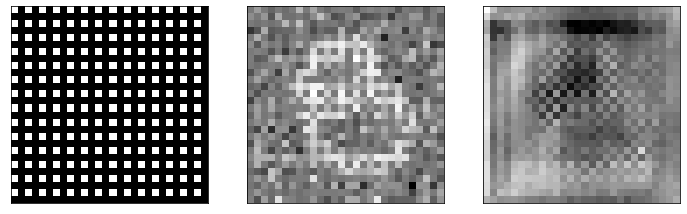

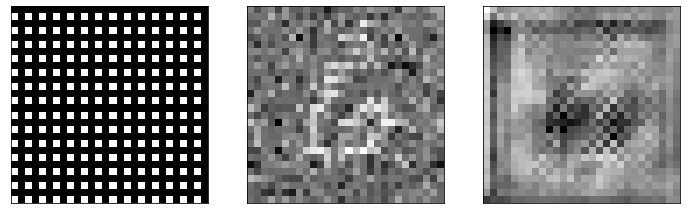

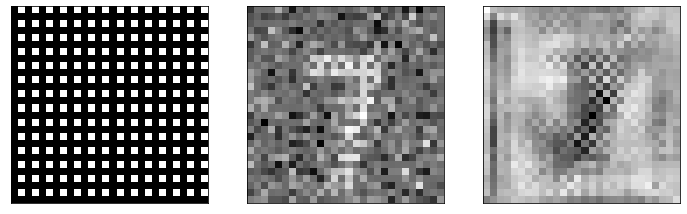

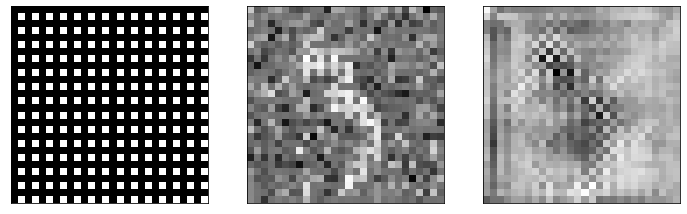

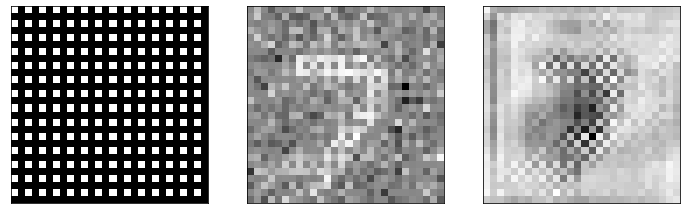

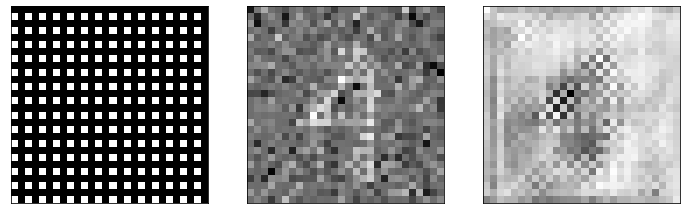

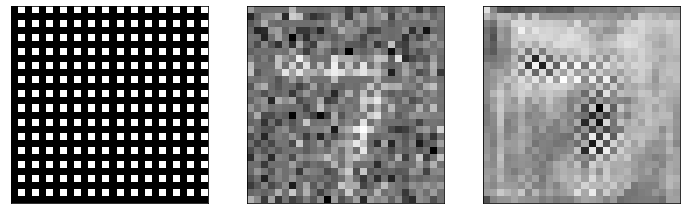

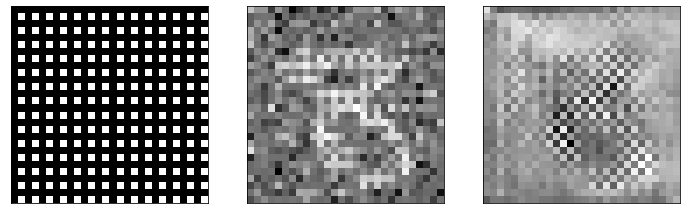

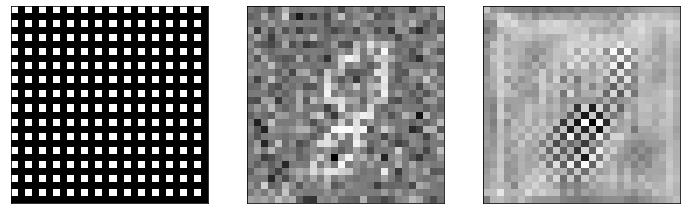

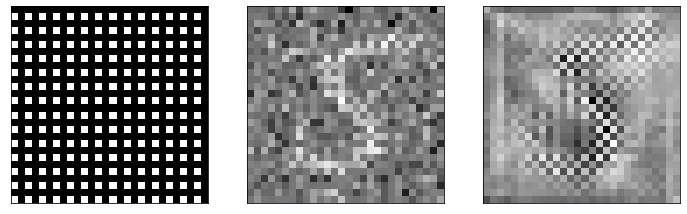

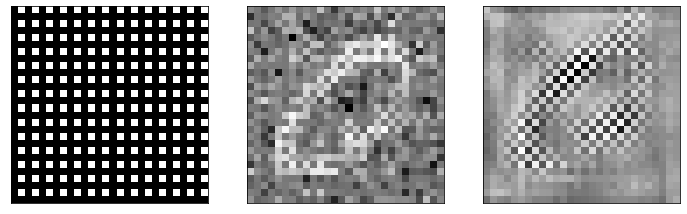

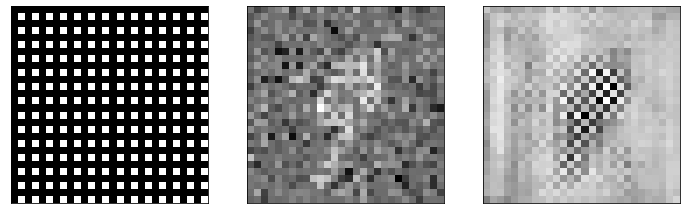

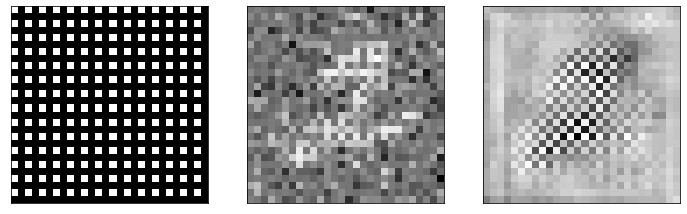

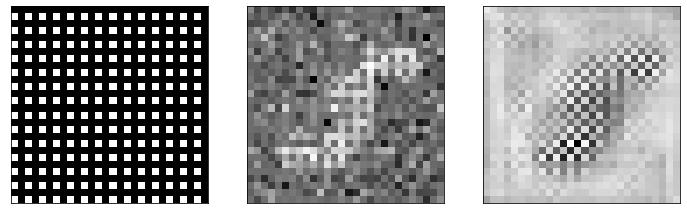

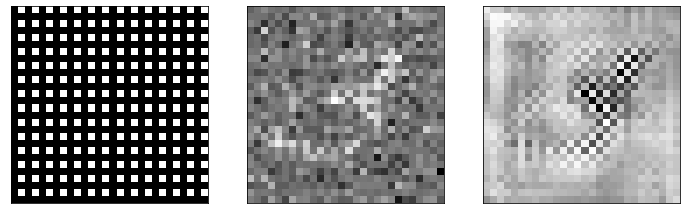

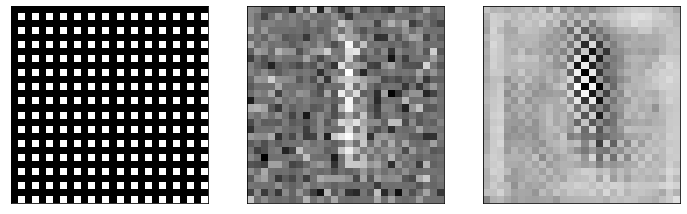

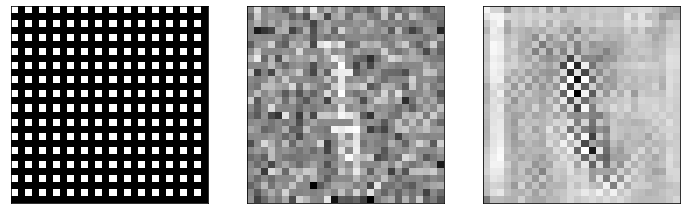

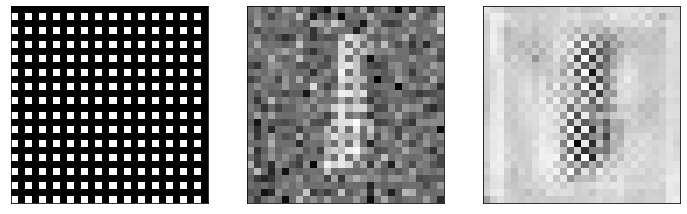

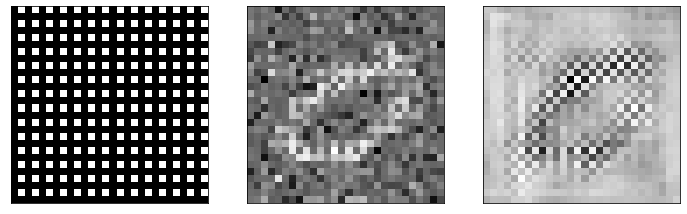

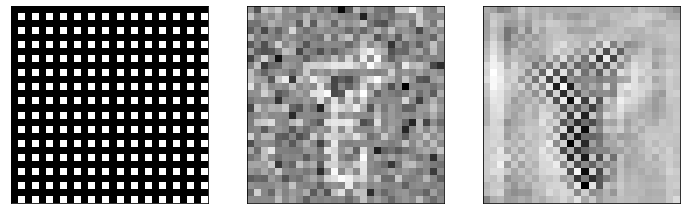

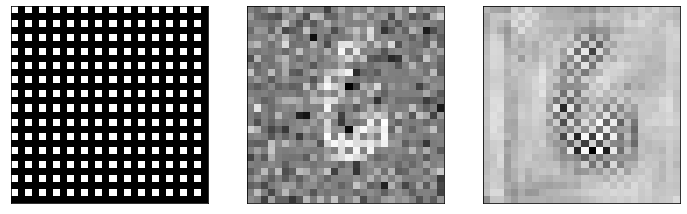

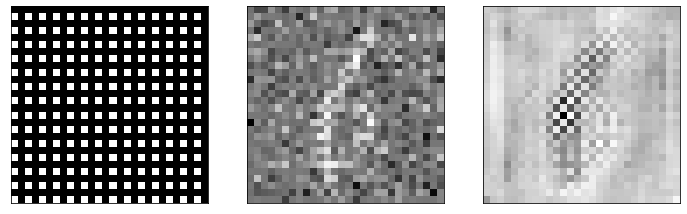

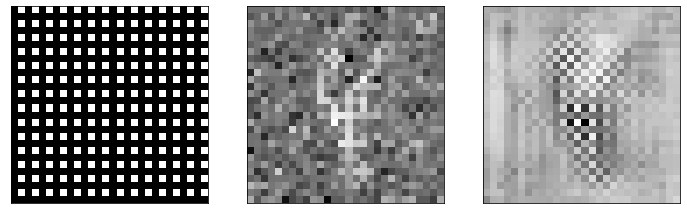

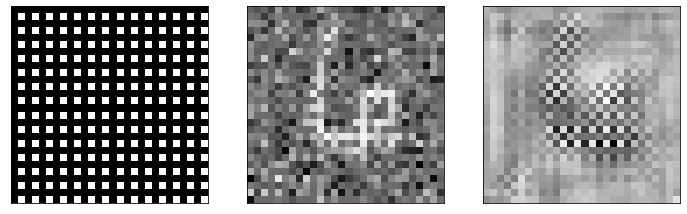

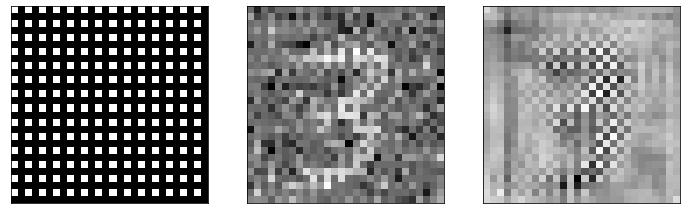

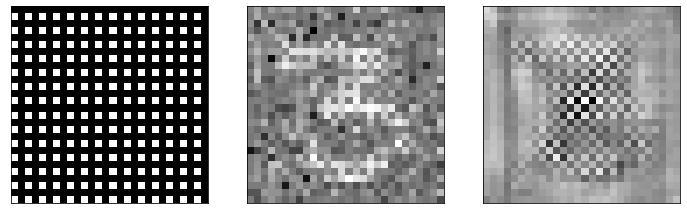

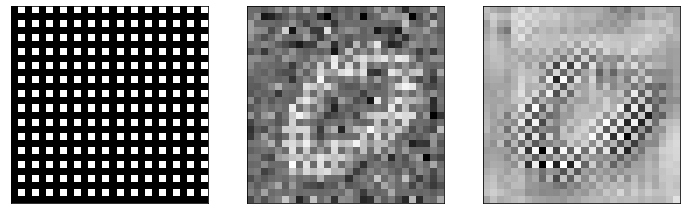

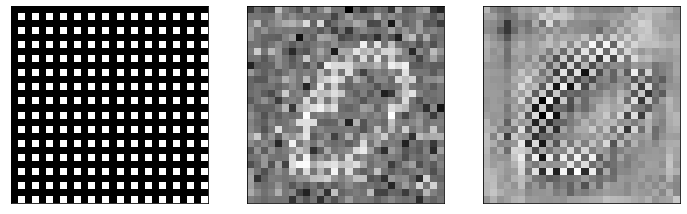

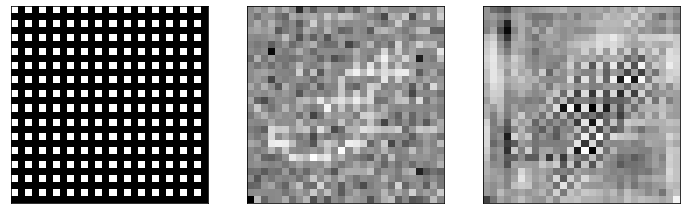

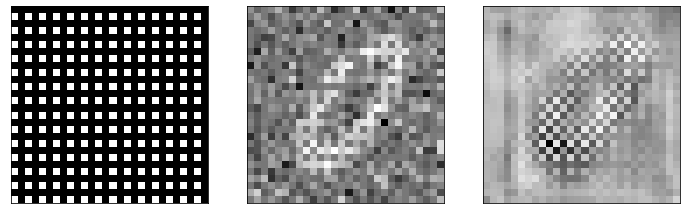

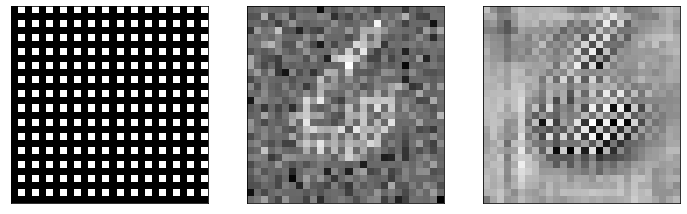

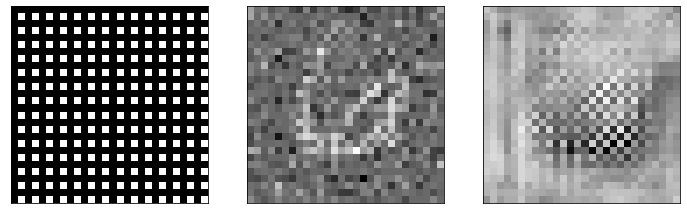

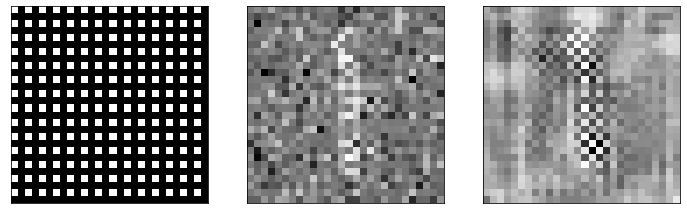

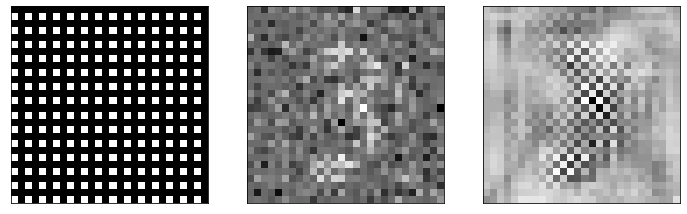

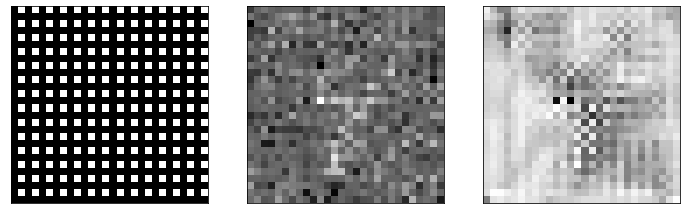

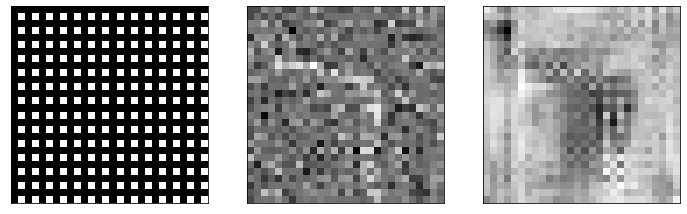

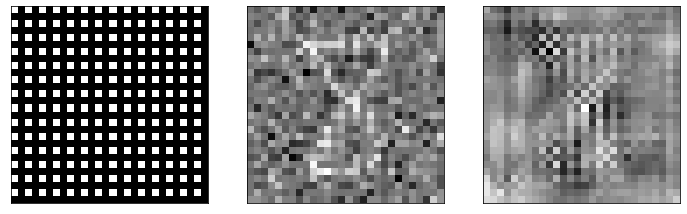

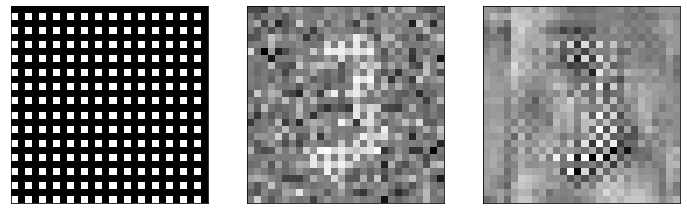

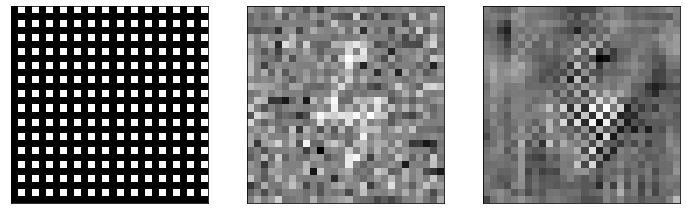

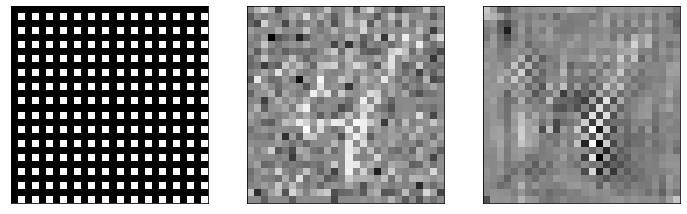

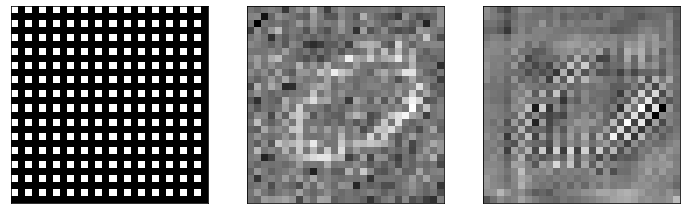

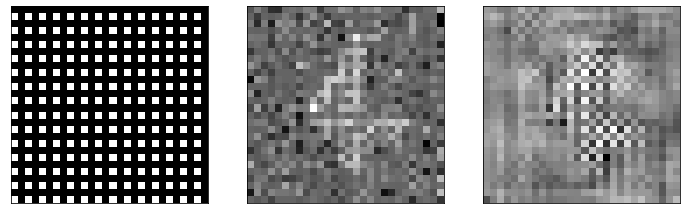

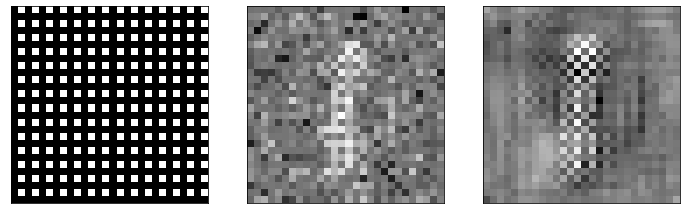

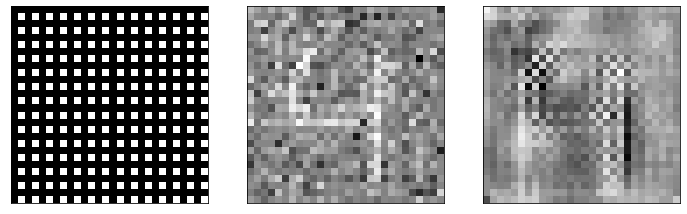

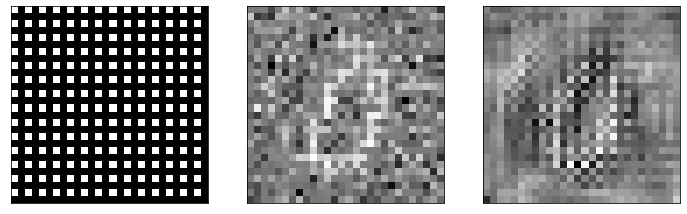

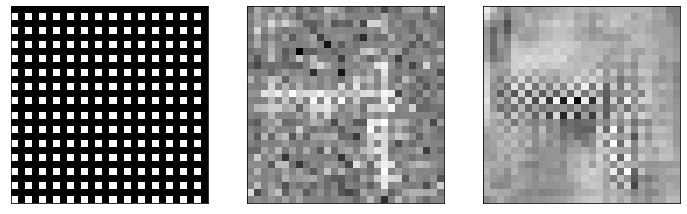

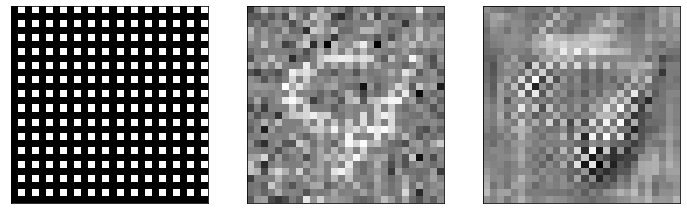

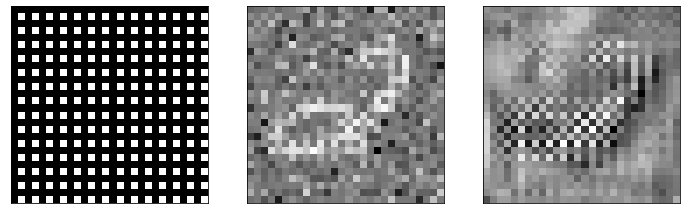

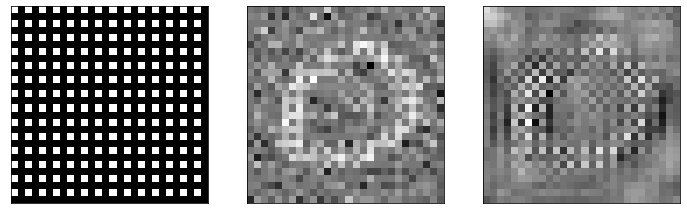

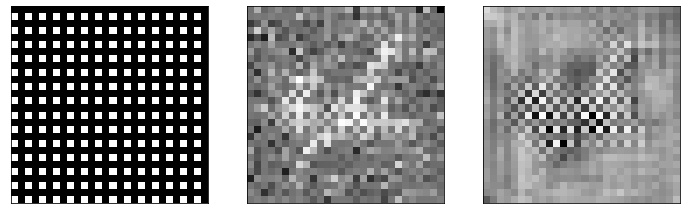

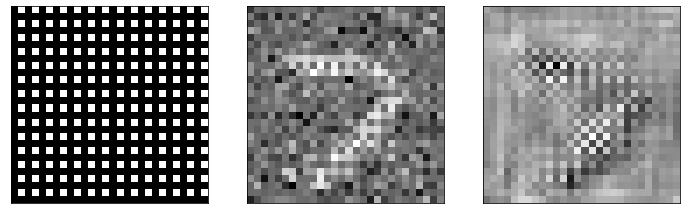

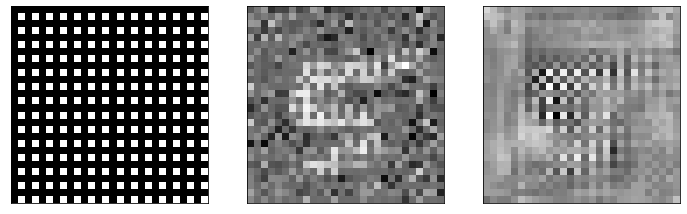

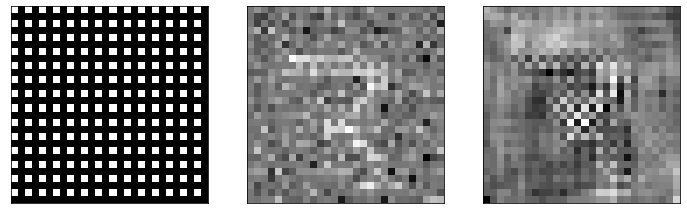

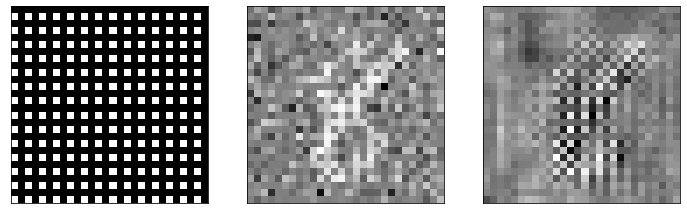

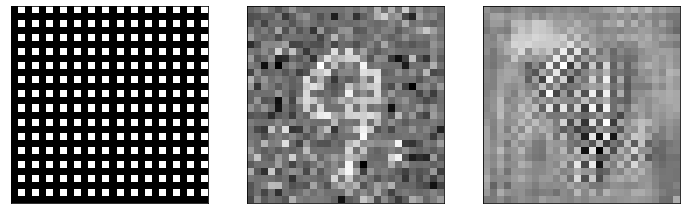

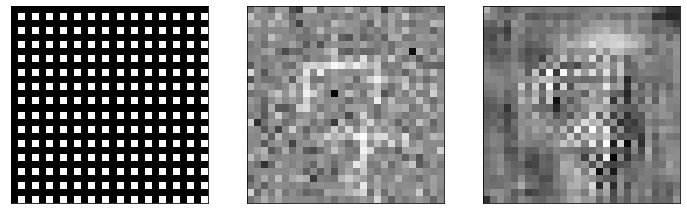

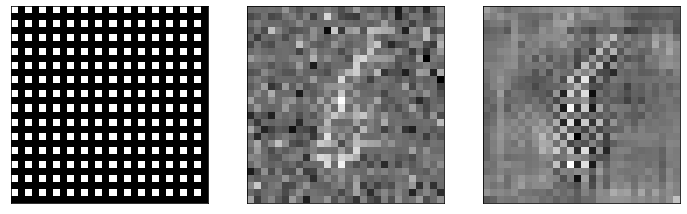

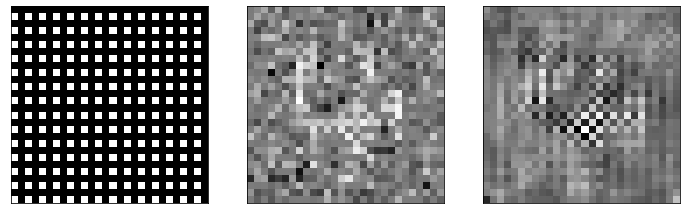

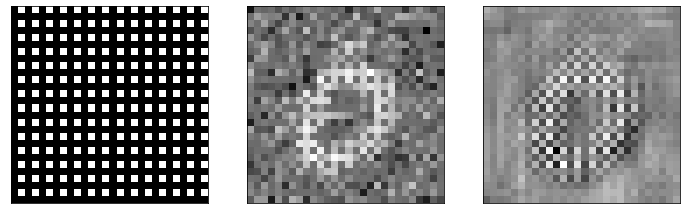

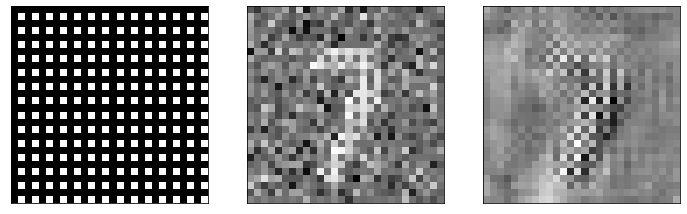

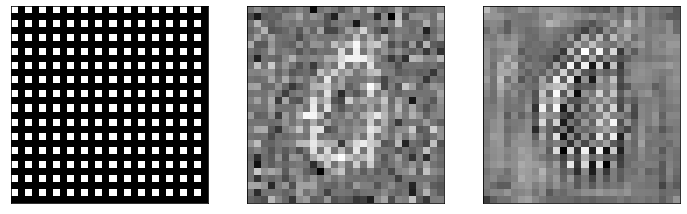

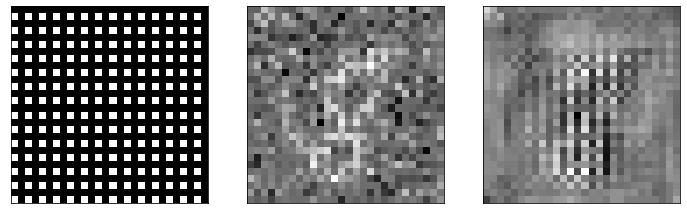

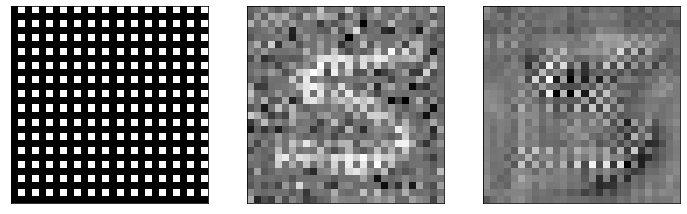

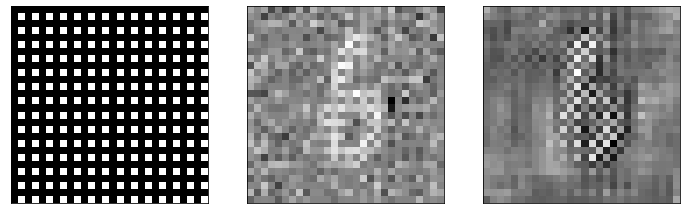

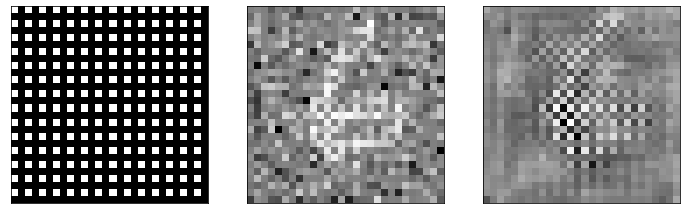

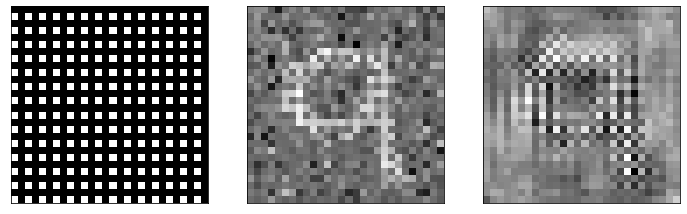

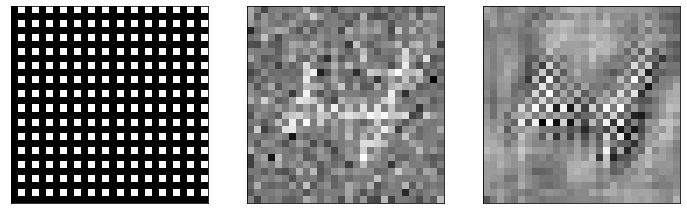

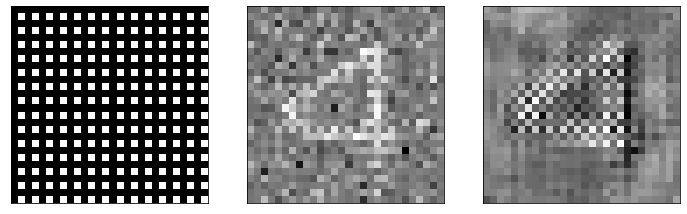

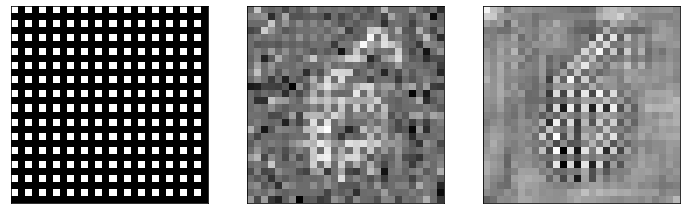

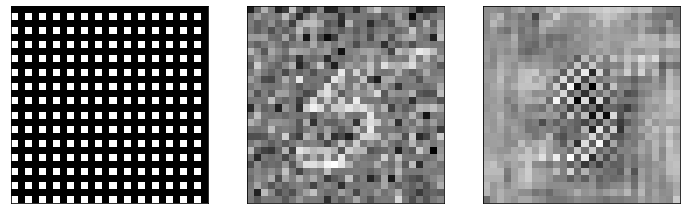

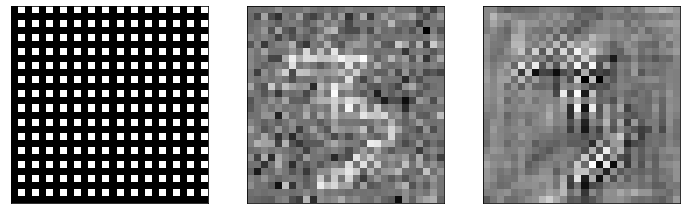

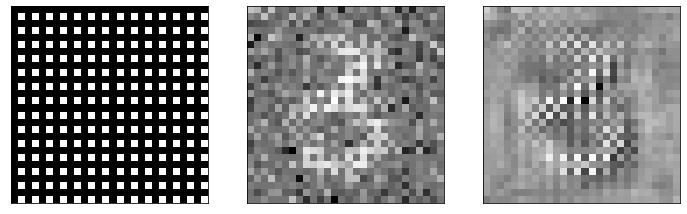

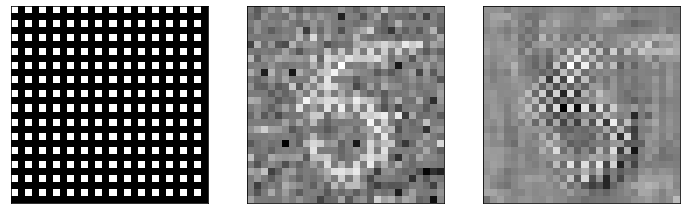

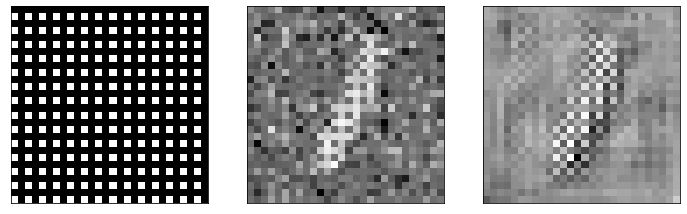

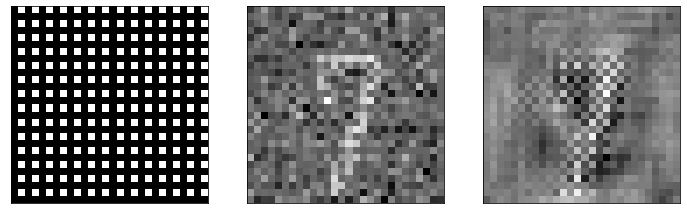

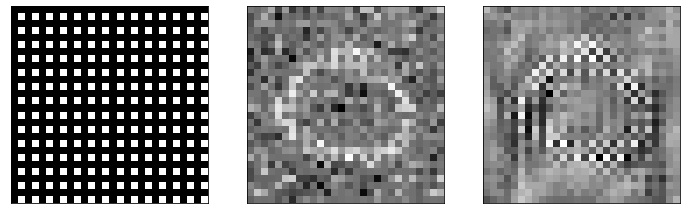

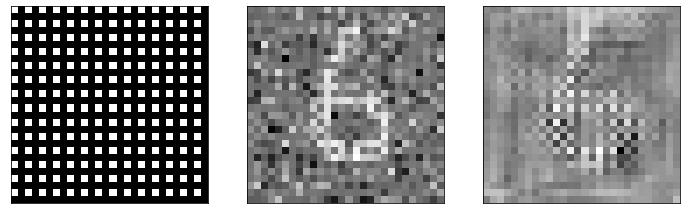

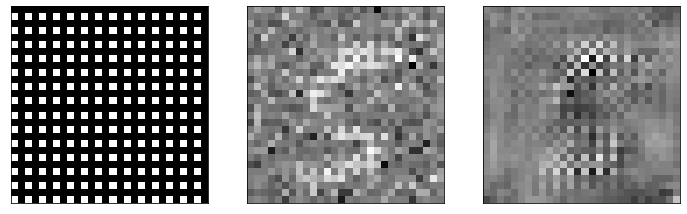

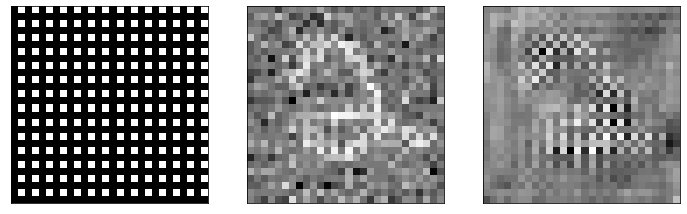

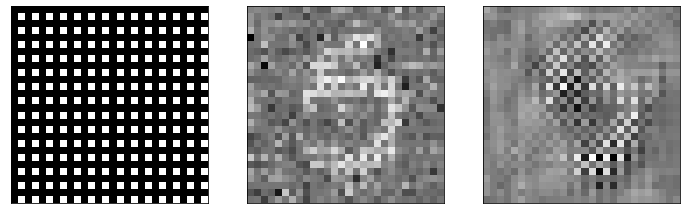

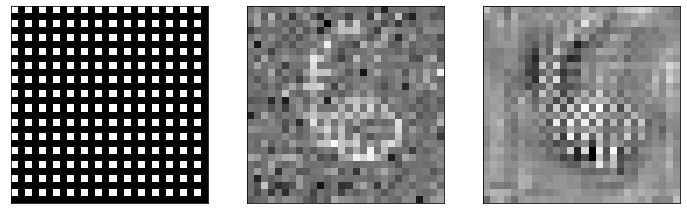

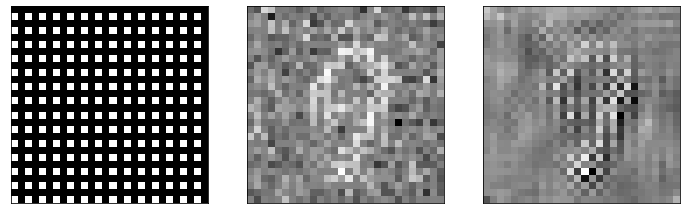

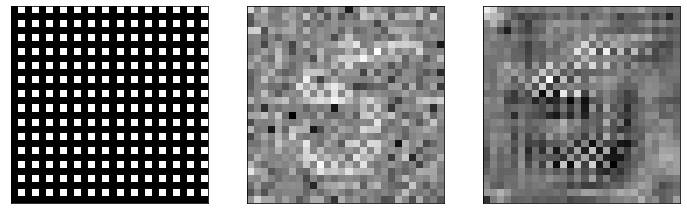

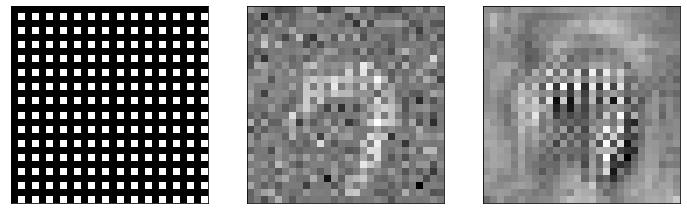

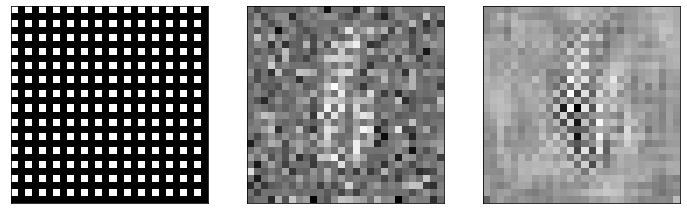

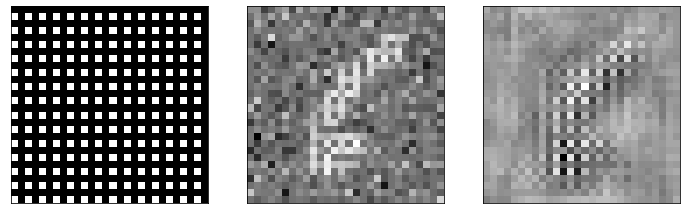

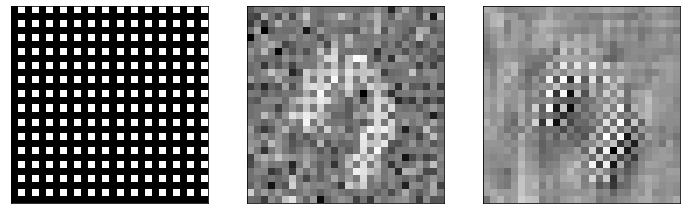

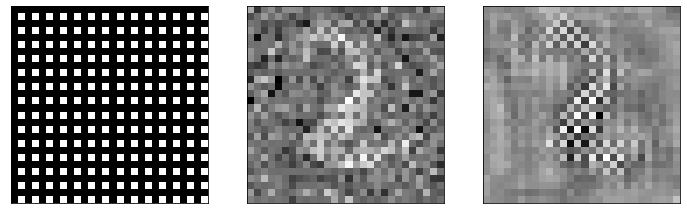

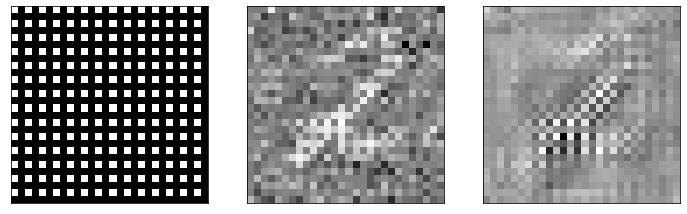

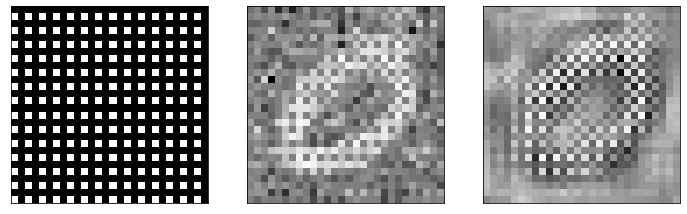

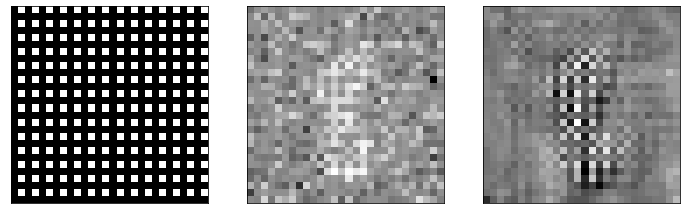

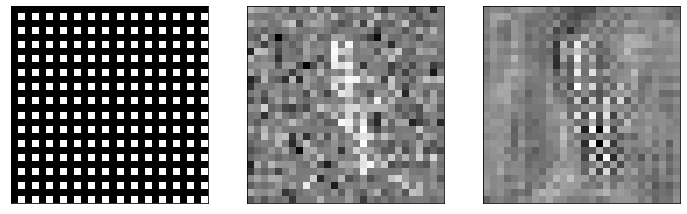

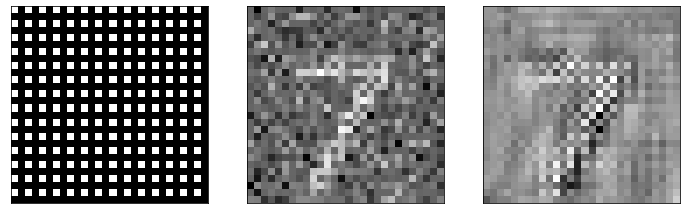

In [52]:
data_loader = DataLoader(noisy_mnist_train, batch_size=32, shuffle=True)

for i, batch in enumerate(data_loader):
    noisy_images, clean_images = batch
    
    net_input, mask = masker.mask(noisy_images, i)
    net_output = model(net_input)
    # plot_tensors([mask, net_input, net_output])
    loss = loss_function(net_output*mask, noisy_images*mask)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        print("Loss (", i, "): \t", round(loss.item(), 4))
        
    if i == 100:
        break

In [14]:
test_data_loader = DataLoader(noisy_mnist_test,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=3)
i, test_batch = next(enumerate(test_data_loader))
noisy, clean = test_batch

With our trained model, we have a choice. We may do a full $J$-invariant reconstruction, or we may just run the noisy data through the network unaltered.

In [15]:
simple_output = model(noisy)
invariant_output = masker.infer_full_image(noisy, model)

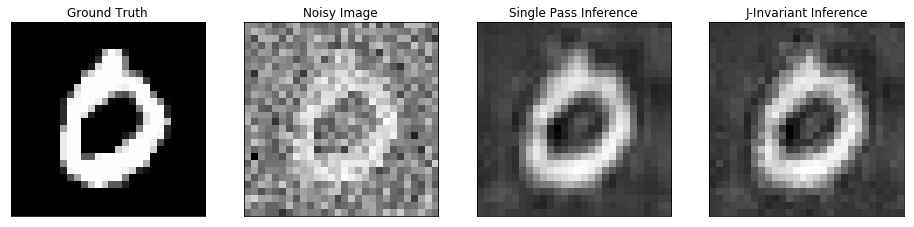

In [16]:
idx = 3
plot_tensors([clean[idx], noisy[idx], simple_output[idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [17]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output).item(), 3))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 3))

Test loss, single pass:  0.017
Test loss, J-invariant:  0.021


While both the simple and invariant output are significantly denoised, the invariant output has a mild pixelation. 

This is due to the fact that neighboring pixels are denoised using different information, leading to discontinuities in the reconstructed output.